Loading new data as requested...
Loading data...
Processing files: ['results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0225.mat']


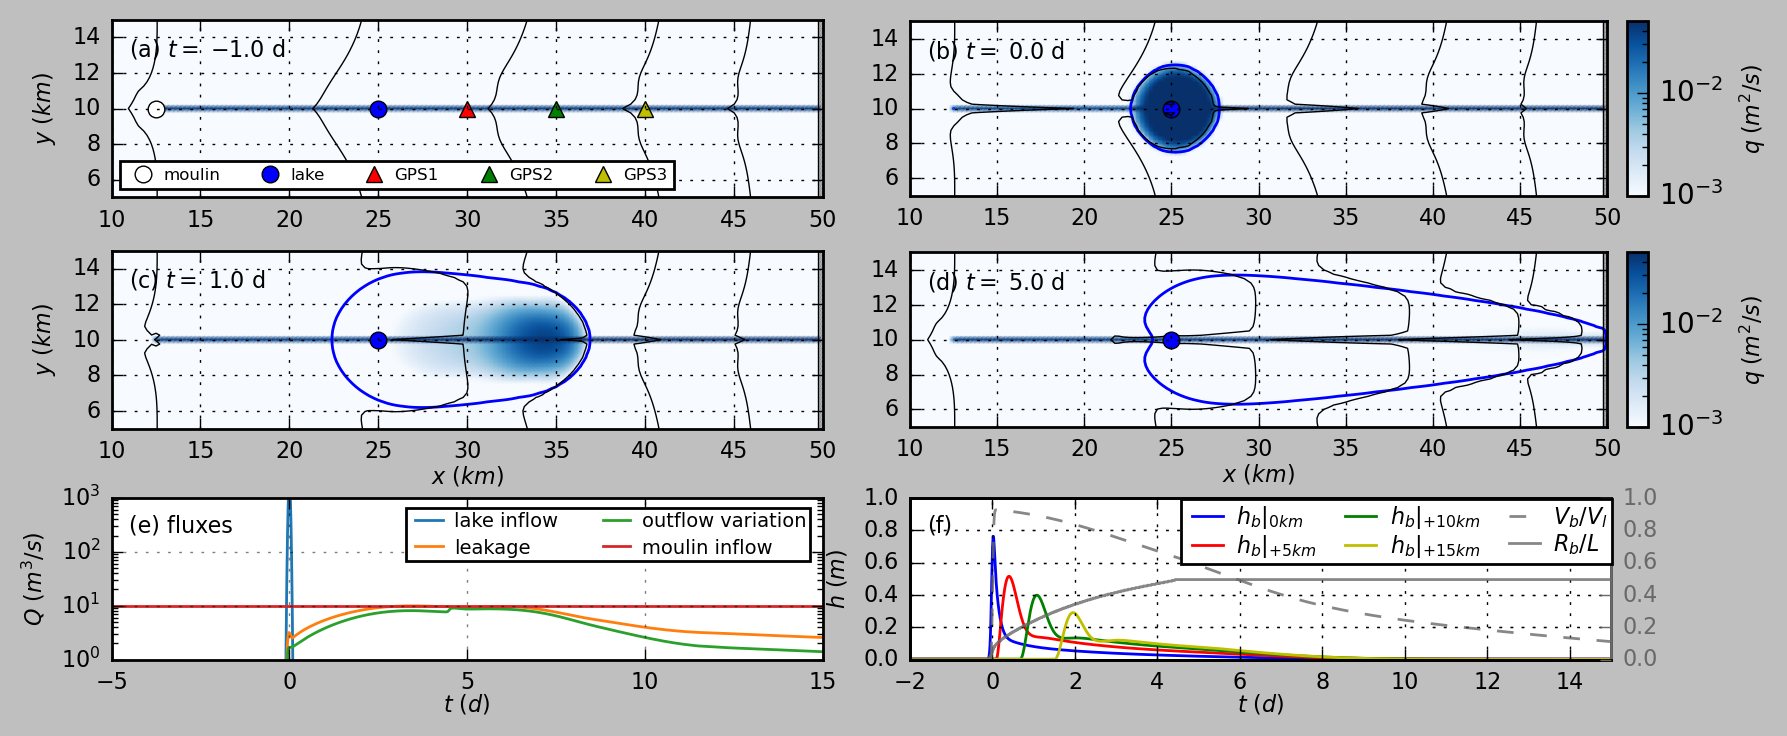

In [9]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Flag to control data import
SKIP_DATA_IMPORT = False
LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data
casename = 'n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage'

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
# norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
norm = LogNorm(vmin=q_min, vmax=q_max)

tdrainge_d = 2.0 * 365 + 20
tmin  = tdrainge_d - 5
tmax  = tdrainge_d + 5
tmin_d = tmin 
tmax_d = tmax
tslice = tdrainge_d + np.array([-1, 0, 1, 5])

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])

    # gps elevations
    #     14 15 16 17    18   19
    #.    8  9  10 11    12   13
    #.    2  3  4   5     6   7
    #.  -1km 0 5km 10km 15km 20km
    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    import subprocess
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)
        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))
    vt = np.array(vt, dtype=np.float64)-tdrainge_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(10, 4), dpi=100)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.style.use('classic')
plt.rc('axes', prop_cycle=cycler('color', colors))
plt.rcParams["figure.dpi"] = 600
# plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
from matplotlib.colors import LogNorm

cmap = plt.cm.Blues
if plot_hb:
    pc = ax1.pcolormesh(xx, yy,
                        ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    # norm = LogNorm(vmin=q_min, vmax=q_max)
    pc = ax1.pcolormesh(xx, yy,
                        ps_qs * vqs[0] + ps_qb * vqb[0] + ps_qs * vqQ[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='k', linewidths=0.5, linestyles='-')
# ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=6, label='moulin')
ax1.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')
# ax1.plot(45.0, 10, 'yo', markersize=6, label='GPS4')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax1.legend(loc='lower left', fontsize=6, frameon=True, handletextpad=0.2, ncol=5, labelspacing=0.2, numpoints=1)
# ax1.legend(loc='upper left', fontsize=6, frameon=False, handletext

ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax2.pcolormesh(xx, yy,
                        ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax2.pcolormesh(xx, yy,
                        ps_qs * vqs[1] + ps_qb * vqb[1] + ps_qs * vqQ[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

ax2.plot(25.0, 10, 'bo', markersize=6, label='lake')
cbar = fig.colorbar(pc, cax=cax2, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='k', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
if plot_hb:
    pc = ax3.pcolormesh(xx, yy,
                        ps_hb * vhb[2] + ps_h * vhs[2] + ps_h * vhc[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax3.pcolormesh(xx, yy,
                        ps_qs * vqs[2] + ps_qb * vqb[2] + ps_qs * vqQ[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='k', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')
ax3.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.xaxis.set_label_coords(0.5, -0.2)
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues

divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax4.pcolormesh(xx, yy,
                        ps_hb * vhb[3] + ps_h * vhs[3] + ps_h * vhc[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax4.pcolormesh(xx, yy,
                        ps_qs * vqs[3] + ps_qb * vqb[3] + ps_qs * vqQ[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

pc.set_edgecolor('face')
cbar = fig.colorbar(pc, cax=cax4, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   

# Plot contour lines for the blister alone
contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='k', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(25.0, 10, 'bo', markersize=6, label='lake')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# set x label position
ax4.xaxis.set_label_coords(0.5, -0.2)

# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, 0])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_left.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-tdrainge_d, Q_b_in, '-',    linewidth=1.0, label='lake inflow')
ax5.plot(t-tdrainge_d, Q_b_dec,'-',    linewidth=1.0, label='leakage')
ax5.plot(t-tdrainge_d, Q_out_b + Q_out_Q + Q_out_q - E, '-', linewidth=1.0, label=r'outflow variation')
ax5.plot(t-tdrainge_d, E,       '-',    linewidth=1.0, label='moulin inflow')

# vertical lines for time points in (a), (b), (c), (d)
# labels = ['(a)', '(b)', '(c)', '(d)']
# for i,t_val in enumerate(vt):
#     ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
#     ax5.text(t_val+0.2, 3e2, labels[i], ha='center', va='bottom', fontsize=6, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-tdrainge_d, tmax_d-tdrainge_d+10)
ax5.set_xlabel('$t~(d)$')
ax5.xaxis.set_label_coords(0.5, -0.2)
ax5.set_ylim(1e0, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
ax5.legend(loc='upper left',  bbox_to_anchor=(0.4, 1.0), frameon=True, fontsize=7, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

# ============== Panel (f): total volume and thickness ==============
ax6 = fig.add_subplot(gs[2, 1])
ax6.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_right  = ax4.get_position()
pos_bottom = gs[2, 1].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_right.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax6_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax6_x0 = pos_right.x0 + (full_width - ax6_width)/2
ax6_pos = [ax6_x0, pos_bottom.y0, ax6_width*0.95, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax6_x0 + ax6_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax6 = fig.add_axes(ax6_pos)
# ============== Plot thickness ==============
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_lake + ps_h*(pts_hc_gps1+pts_hs_gps1), 'b-', linewidth=1.0, label='$h_b|_{0km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps2 + ps_h*(pts_hc_gps2+pts_hs_gps2), 'r-', linewidth=1.0, label='$h_b|_{+5km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps3 + ps_h*(pts_hc_gps3+pts_hs_gps3), 'g-', linewidth=1.0, label='$h_b|_{+10km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps4 + ps_h*(pts_hc_gps4+pts_hs_gps4), 'y-', linewidth=1.0, label='$h_b|_{+15km}$', alpha=1.0)

ax6.set_xlim(tmin_d+3-tdrainge_d, tmax_d+10-tdrainge_d)
ax6.set_xlabel('$t~(d)$')
ax6.xaxis.set_label_coords(0.5, -0.2)
ax6.set_ylim(0, 1.0)
ax6.set_ylabel(r'$h~(m)$')
ax6.text(0.025, 0.9, '(f)', transform=ax6.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
# ax6.legend(loc='lower left',  bbox_to_anchor=(0.1, -0.7), frameon=True, fontsize=8, ncol=4,
#            labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax6.grid(alpha=1.0)

# ============== Plot volume ==============
ax6_twin = ax6.twinx()
ax6_twin.plot(t-tdrainge_d, V_b/1e7, '--', color='dimgray', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
ax6_twin.plot(t-tdrainge_d, R_b/5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

ax6_twin.set_xlabel('$t~(d)$')
# ax6_twin.set_ylabel(r'$V_b/V_l$', fontsize=8)
ax6_twin.set_ylim(0, 1.0)
ax6_twin.tick_params(axis='y', labelsize=8)
ax6_twin.grid(alpha=0.5)
# make axis and label blue
ax6_twin.spines['right'].set_color('dimgray')
ax6_twin.yaxis.label.set_color('dimgray')
ax6_twin.tick_params(axis='y', colors='dimgray')

# combine legend entries from ax6 and its twin
handles1, labels1 = ax6.get_legend_handles_labels()
handles2, labels2 = ax6_twin.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left',
    bbox_to_anchor=(0.37, 1.06), fontsize=8, ncol=3,
    labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
    frameon=True, framealpha=1.0)

fig.savefig(
    './results/figures/Fig3_summertime.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()

Loading new data as requested...
Loading data...
Processing files: ['results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0225.mat']


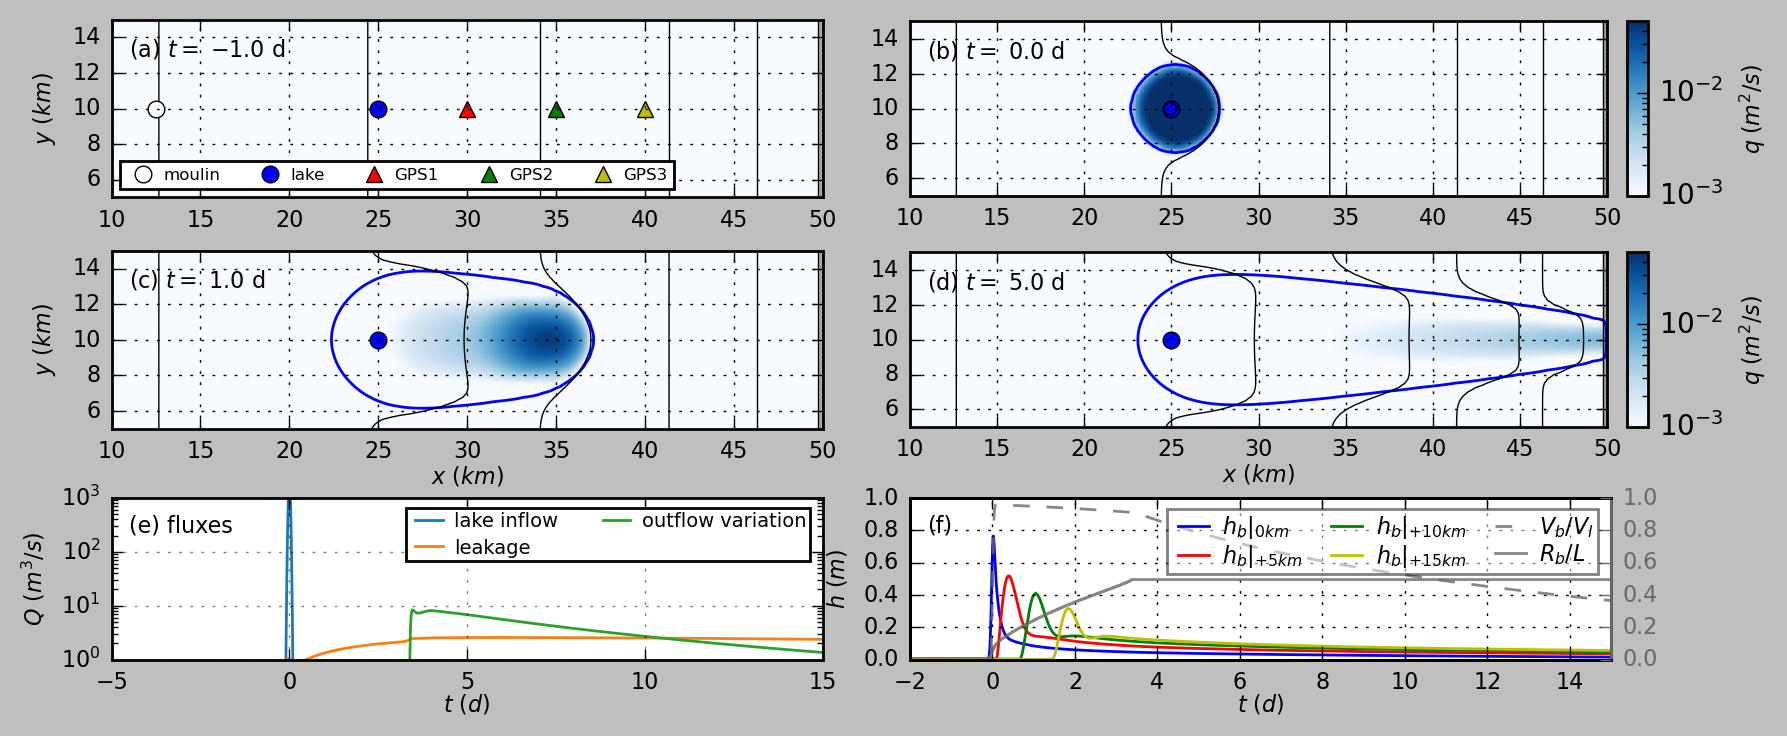

In [ ]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

casename = 'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e6_drainage'
# Flag to control data import
SKIP_DATA_IMPORT = False
LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
# norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
norm = LogNorm(vmin=q_min, vmax=q_max)

tdrainge_d = 2.0 * 365 + 20
tmin  = tdrainge_d - 5
tmax  = tdrainge_d + 5
tmin_d = tmin 
tmax_d = tmax
tslice = tdrainge_d + np.array([-1, 0, 1, 5])

# Plotting setup
fontsize_panel = 8
fontsize_label = 8
fontsize_legend = 8

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])

    # gps elevations
    #     14 15 16 17    18   19
    #.    8  9  10 11    12   13
    #.    2  3  4   5     6   7
    #.  -1km 0 5km 10km 15km 20km
    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    import subprocess
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)
        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))
    vt = np.array(vt, dtype=np.float64)-tdrainge_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(10, 4), dpi=100)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.style.use('classic')
plt.rc('axes', prop_cycle=cycler('color', colors))
plt.rcParams["figure.dpi"] = 600
# plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
from matplotlib.colors import LogNorm

cmap = plt.cm.Blues
if plot_hb:
    pc = ax1.pcolormesh(xx, yy,
                        ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    # norm = LogNorm(vmin=q_min, vmax=q_max)
    pc = ax1.pcolormesh(xx, yy,
                        ps_qs * vqs[0] + ps_qb * vqb[0] + ps_qs * vqQ[0],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='k', linewidths=0.5, linestyles='-')
# ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=6, label='moulin')
ax1.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')
# ax1.plot(45.0, 10, 'yo', markersize=6, label='GPS4')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax1.legend(loc='lower left', fontsize=6, frameon=True, handletextpad=0.2, ncol=5, labelspacing=0.2, numpoints=1)
# ax1.legend(loc='upper left', fontsize=6, frameon=False, handletext

ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax2.pcolormesh(xx, yy,
                        ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax2.pcolormesh(xx, yy,
                        ps_qs * vqs[1] + ps_qb * vqb[1] + ps_qs * vqQ[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

ax2.plot(25.0, 10, 'bo', markersize=6, label='lake')
cbar = fig.colorbar(pc, cax=cax2, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='k', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
if plot_hb:
    pc = ax3.pcolormesh(xx, yy,
                        ps_hb * vhb[2] + ps_h * vhs[2] + ps_h * vhc[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax3.pcolormesh(xx, yy,
                        ps_qs * vqs[2] + ps_qb * vqb[2] + ps_qs * vqQ[2],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Plot contour lines for the blister alone
contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='k', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')
ax3.plot(25.0, 10, 'bo', markersize=6, label='lake')
ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.xaxis.set_label_coords(0.5, -0.2)
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues

divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax4.pcolormesh(xx, yy,
                        ps_hb * vhb[3] + ps_h * vhs[3] + ps_h * vhc[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax4.pcolormesh(xx, yy,
                        ps_qs * vqs[3] + ps_qb * vqb[3] + ps_qs * vqQ[3],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

pc.set_edgecolor('face')
cbar = fig.colorbar(pc, cax=cax4, orientation='vertical')
cbar.set_label('$h\\;(m)$') if plot_hb else cbar.set_label('$q\\;(m^2/s)$')
cbar.ax.tick_params(labelsize=10)   

# Plot contour lines for the blister alone
contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='k', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(25.0, 10, 'bo', markersize=6, label='lake')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# set x label position
ax4.xaxis.set_label_coords(0.5, -0.2)

# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, 0])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_left.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-tdrainge_d, Q_b_in, '-',    linewidth=1.0, label='lake inflow')
ax5.plot(t-tdrainge_d, Q_b_dec,'-',    linewidth=1.0, label='leakage')
ax5.plot(t-tdrainge_d, Q_out_b + Q_out_Q + Q_out_q - E, '-', linewidth=1.0, label=r'outflow variation')
# ax5.plot(t-tdrainge_d, E,       '-',    linewidth=1.0, label='moulin inflow')

# vertical lines for time points in (a), (b), (c), (d)
# labels = ['(a)', '(b)', '(c)', '(d)']
# for i,t_val in enumerate(vt):
#     ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
#     ax5.text(t_val+0.2, 3e2, labels[i], ha='center', va='bottom', fontsize=6, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-tdrainge_d, tmax_d-tdrainge_d+10)
ax5.set_xlabel('$t~(d)$')
ax5.xaxis.set_label_coords(0.5, -0.2)
ax5.set_ylim(1e0, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
ax5.legend(loc='upper left',  bbox_to_anchor=(0.4, 1.0), frameon=True, fontsize=7, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

# ============== Panel (f): total volume and thickness ==============
ax6 = fig.add_subplot(gs[2, 1])
ax6.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_right  = ax4.get_position()
pos_bottom = gs[2, 1].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_right.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax6_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax6_x0 = pos_right.x0 + (full_width - ax6_width)/2
ax6_pos = [ax6_x0, pos_bottom.y0, ax6_width*0.95, pos_bottom.height-0.02]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax6_x0 + ax6_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax6 = fig.add_axes(ax6_pos)
# ============== Plot thickness ==============
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_lake + ps_h*(pts_hc_gps1+pts_hs_gps1), 'b-', linewidth=1.0, label='$h_b|_{0km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps2 + ps_h*(pts_hc_gps2+pts_hs_gps2), 'r-', linewidth=1.0, label='$h_b|_{+5km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps3 + ps_h*(pts_hc_gps3+pts_hs_gps3), 'g-', linewidth=1.0, label='$h_b|_{+10km}$', alpha=1.0)
ax6.plot(t-tdrainge_d, ps_hb*pts_hb_gps4 + ps_h*(pts_hc_gps4+pts_hs_gps4), 'y-', linewidth=1.0, label='$h_b|_{+15km}$', alpha=1.0)

ax6.set_xlim(tmin_d+3-tdrainge_d, tmax_d+10-tdrainge_d)
ax6.set_xlabel('$t~(d)$')
ax6.xaxis.set_label_coords(0.5, -0.2)
ax6.set_ylim(0, 1.0)
ax6.set_ylabel(r'$h~(m)$')
ax6.text(0.025, 0.9, '(f)', transform=ax6.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False)
# ax6.legend(loc='lower left',  bbox_to_anchor=(0.1, -0.7), frameon=True, fontsize=8, ncol=4,
#            labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax6.grid(alpha=1.0)

# ============== Plot volume ==============
ax6_twin = ax6.twinx()
ax6_twin.plot(t-tdrainge_d, V_b/1e7, '--', color='dimgray', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
ax6_twin.plot(t-tdrainge_d, R_b/5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

ax6_twin.set_xlabel('$t~(d)$')
# ax6_twin.set_ylabel(r'$V_b/V_l$', fontsize=8)
ax6_twin.set_ylim(0, 1.0)
ax6_twin.tick_params(axis='y', labelsize=8)
ax6_twin.grid(alpha=0.0)
# make axis and label blue
ax6_twin.spines['right'].set_color('dimgray')
ax6_twin.yaxis.label.set_color('dimgray')
ax6_twin.tick_params(axis='y', colors='dimgray')

# combine legend entries from ax6 and its twin
handles1, labels1 = ax6.get_legend_handles_labels()
handles2, labels2 = ax6_twin.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left',
    bbox_to_anchor=(0.35, 1.00), fontsize=8, ncol=3,
    labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
    frameon=True, framealpha=0.5)

fig.savefig(
    './results/figures/Fig2_wintertime.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)
plt.show()

Loading new data as requested...
Loading data...
Processing files: ['results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0222.mat', 'results/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0224.mat']


/var/folders/rl/0fstgkgs7t93dk9q8yhnw9lc0000gs/T/ipykernel_13920/1623305558.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for colorbar


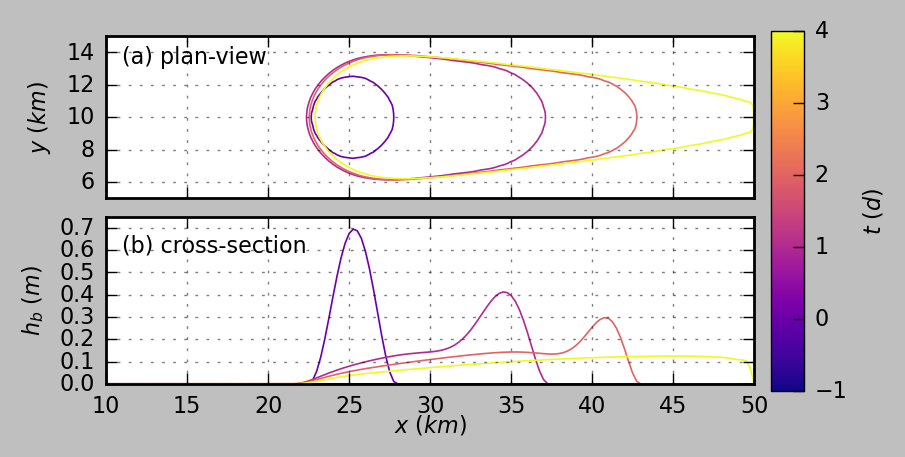

In [ ]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Flag to control data import
SKIP_DATA_IMPORT = True
LOAD_NEW_DATA = 1  # Set to True to load new data, False to use existing data
casename = 'n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage'

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
# norm = PowerNorm(gamma=1, vmin=q_min, vmax=q_max)
norm = LogNorm(vmin=q_min, vmax=q_max)

tdrainge_d = 2.0 * 365 + 20
tmin  = tdrainge_d - 5
tmax  = tdrainge_d + 5
tmin_d = tmin 
tmax_d = tmax
tslice = tdrainge_d + np.array([-1, 0, 1, 2, 4])

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])


    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    import subprocess
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)
        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))

    vt = np.array(vt, dtype=np.float64)-tdrainge_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(4.5, 3), dpi=100)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], wspace=0.05, hspace=0.3)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
# ax3 = plt.subplot(gs[2, 0])
cax = plt.subplot(gs[:, 1])

pos1 = ax1.get_position()
pos2 = ax2.get_position()
# pos3 = ax3.get_position()
poscax = cax.get_position()

vertical_gap = -0.008
# Set ax2's bottom to be just below ax1's top
new_pos2_bottom = pos1.y0 - 0.8*pos2.height - vertical_gap
ax2.set_position([pos2.x0, new_pos2_bottom, pos2.width, 0.8*pos2.height])
# ax3.set_position([pos3.x0, pos3.y0 +0.07
#                   , pos3.width, pos3.height])
cax.set_position([poscax.x0, pos2.y0+0.17
                  , poscax.width, pos1.y0+ pos1.height - pos2.y0 - 0.2])

plt.style.use('classic')
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 7  # 坐标轴标签字体大小
plt.rcParams['xtick.labelsize'] = 7 # X轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 7 # Y轴刻度字体大小
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

import matplotlib.cm as cm
from matplotlib.lines import Line2D
cmap = plt.cm.plasma
norm = PowerNorm(gamma=1.0, vmin=np.min(vt), vmax=np.max(vt))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# ================= Panel (a): blister profile (plan view) =================
for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    CS = ax1.contour(xx, yy, ps_hb * vhb[i], levels=[0.01], colors=[color_i])

cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('$t~(d)$')

ax1.set_xlim(10, 50)
ax1.set_ylim(5, 15)
ax1.tick_params(axis='x', labelbottom=False)  # 隐藏x轴刻度标签
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal', adjustable='box')
ax1.text(0.025, 0.8, '(a) plan-view', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=8, clip_on=False)
ax1.grid(alpha=0.5)

# ================= Panel (b): blister profile (cross section) =================
p = []
for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    p.append(ax2.plot(xx[:,0], ps_hb * vhb[i][:,nJ//2], color=color_i))  # Plot each time step

ax2.set_xlabel('$x~(km)$')
ax2.xaxis.set_label_coords(0.5, -0.175)
ax2.set_ylabel('$h_b~(m)$')
ax2.set_xlim(10, 50)
ax2.set_ylim(0, 0.75)
ax2.text(0.025, 0.9, '(b) cross-section', transform=ax2.transAxes,
         ha='left', va='top', fontsize=8, clip_on=False, color='black')
ax2.grid(alpha=0.5)

# # ================= Panel (c): Time series of discharge =================
# ax3.plot(t-tdrainge_d, R_b/5e4, color='k', label='$R/L$')
# ax3.plot(t-tdrainge_d, V_b/1e7, color='b', label='$V/V_l$')

# ax3.set_xlabel('$t(d)$',fontsize=8)
# ax3.set_xlim(tmin_d+2-tdrainge_d, tmax_d+2-tdrainge_d)
# ax3.set_ylim(0, 1)
# legend = ax3.legend(loc='lower left', fontsize='small')
# legend.get_frame().set_linewidth(0.5)  # Adjust the linewidth of the legend box
# ax3.text(0.025, 0.9, '(c) time series', transform=ax3.transAxes,
#          ha='left', va='top', fontsize=8, clip_on=False, color='black')
# ax3.grid(alpha=0.5)

# # Add vertical lines for each time slice
# for i in range(len(vt)):
#     ax3.axvline(x=vt[i], color=cmap(norm(vt[i])), linewidth=0.8, linestyle='--', dashes=(2, 2))

fig.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for colorbar

fig.savefig(
    './results/figures/Fig4_cross_section.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()


Processing: n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage, Average Speed: 4.0946 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e6_drainage, Average Speed: 1.3314 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage, Average Speed: 0.1700 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e6_drainage, Average Speed: 0.0194 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage, Average Speed: 0.0020 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e6_drainage, Average Speed: nan m/s
Processing: n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e6_drainage, Average Speed: nan m/s
Processing: n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e7_drainage, Average Speed: 7.9420 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e7_drainage, Average Speed: 5.8652 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e7_drainage, Average Speed: 3.1113 m/s
Processing: n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e7_drainage, Average Speed: 0.7548 m/s
Processing: n2d_0m3s_

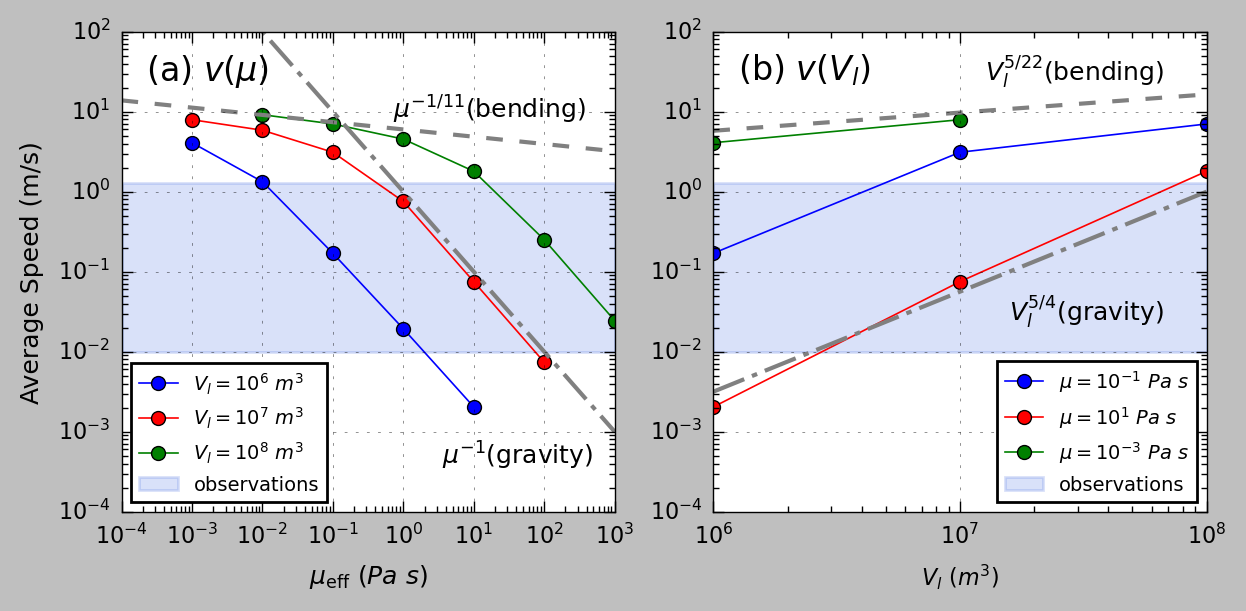

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio

class NevisCaseAnalyzer:
    """
    A class for loading and analyzing NEVIS .mat result files.

    This class can process one or more casenames, calculate the front propagation speed
    for each case, and store the results for later use.
    """
    def __init__(self, results_dir='results'):
        """
        Initialize the analyzer.

        Args:
            results_dir (str): Root directory containing casename result folders.
        """
        self.results_dir = results_dir
        self.results = {}

    def _load_and_process_case(self, casename):
        """
        Load and process data for a single case.
        """
        mat_path = os.path.join(self.results_dir, casename, f"{casename}.mat")
        try:
            raw = sio.loadmat(mat_path, squeeze_me=True)
        except FileNotFoundError:
            print(f"Warning: File not found {mat_path}, skipping this case.")
            return None

        # Extract data
        tt = raw['tt']
        ps = raw['ps']
        
        # Type conversion
        ps_x = np.float64(ps['x'])
        ps_t = np.float64(ps['t'])
        
        # Calculate derived quantities
        R_b = ps_x * np.float64(tt['Rb'])
        t = (ps_t / (24 * 60 * 60)) * np.float64(tt['t'])

        # Core analysis logic
        R_b = np.where(R_b > 25e3, 0.0, R_b)  # Filter outliers
        if not np.any(R_b > 0):
            print(f"Warning: In {casename}, R_b has no positive values, unable to calculate speed.")
            return None
            
        R_max = np.max(R_b)
        
        # Find start and end indices
        # start_indices = np.where(t > tdrainge_d)[0]
        start_indices = np.where((R_b > 0.2 * R_max) & (R_b < 0.5 * R_max))[0]
        end_indices = np.where((R_b > 0.8 * R_max) & (R_b < R_max))[0]

        if len(start_indices) == 0 or len(end_indices) == 0:
            print(f"Warning: Unable to determine start or end points in {casename}.")
            return None
            
        idx_start = start_indices[0]
        idx_end = end_indices[0]

        # Calculate average speed
        delta_R = R_b[idx_end] - R_b[idx_start]
        delta_t = t[idx_end] - t[idx_start]
        
        if delta_t == 0:
            print(f"Warning: Time difference is zero in {casename}, unable to calculate speed.")
            return None

        avg_speed = (delta_R / delta_t) / (24 * 3600)  # m/s
        if avg_speed < 1e-3 or avg_speed > 1e1:
            avg_speed = np.nan  # Set to NaN if speed is too low
        print(f"Processing: {casename}, Average Speed: {avg_speed:.4f} m/s")
        return avg_speed

    def run_analysis(self, casenames):
        """
        Run analysis for a list of casenames.

        Args:
            casenames (list): List of casename strings to analyze.
        
        Returns:
            list: List of calculated average speeds.
        """
        avg_speeds = []
        for casename in casenames:
            speed = self._load_and_process_case(casename)
            if speed is not None:
                avg_speeds.append(speed)
        
        # Store results in the instance
        self.results['avg_speeds'] = avg_speeds
        return np.array(avg_speeds)


fontsize_panel = 9

casenames1 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e6_drainage']

casenames2 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e7_drainage']

casenames3 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_2_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e0_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e2_hbreg5e_3_V1e8_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e3_hbreg5e_3_V1e8_drainage']

fig,ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 8  # 坐标轴标签字体大小
plt.rcParams['xtick.labelsize'] = 8 # X轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 8 # Y轴刻度字体大小
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# vmu = np.array([1e-4, 1e-3,1e-2,1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
vmu = np.array([1e-3,1e-2,1e-1, 1e0, 1e1, 1e2, 1e3])
# vmu = np.array([1e3])
t_start = []
t_end = []

ax = plt.subplot(121)
analyzer = NevisCaseAnalyzer()
avg_speed1 = analyzer.run_analysis(casenames1)
avg_speed2 = analyzer.run_analysis(casenames2)
avg_speed3 = analyzer.run_analysis(casenames3)

ax.plot(vmu, avg_speed1, marker='o', markersize=5, linestyle='-', color='b', label=r'$V_l=10^6~m^3$')
ax.plot(vmu, avg_speed2, marker='o', markersize=5, linestyle='-', color='r', label=r'$V_l=10^7~m^3$')
ax.plot(vmu, avg_speed3, marker='o', markersize=5, linestyle='-', color='g', label=r'$V_l=10^8~m^3$')

# plot theoretical lines
vmutheory = np.linspace(1e-4, 1e3, 10)
ax.plot(vmutheory, 6e0*vmutheory**(-1/11), linewidth=1.5, linestyle='--', color='gray') 
ax.plot(vmutheory, vmutheory**(-1), linewidth=1.5, linestyle=(0, (12, 3, 2, 3)), color='gray')
ax.text(0.55,0.82, r'$\mu^{-1/11}$(bending)', fontsize=fontsize_panel, color='black', transform=ax.transAxes)
ax.text(0.65,0.10, r'$\mu^{-1}$(gravity)', fontsize=fontsize_panel, color='black', transform=ax.transAxes)

ax.axhspan(0.01, 1.3, color='royalblue', alpha=0.2, label='observations')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\mu_{\text{eff}}~(Pa~s)$',fontsize=fontsize_panel)
ax.set_ylabel('Average Speed (m/s)',fontsize=fontsize_panel)
ax.tick_params(axis='both', labelsize=fontsize_panel-1)
ax.set_ylim(1e-4, 1e2)
ax.set_xlim(1e-4, 1e3)
ax.text(0.05, 0.9, r'(a) $v\left(\mu\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)
ax.legend(loc='lower left', fontsize=fontsize_panel-2, numpoints=1)

# ================= Panel (b): speed vs volume =================
ax = plt.subplot(122)
vVl = np.array([1e6, 1e7, 1e8])

casenames1 = ['n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_1_hbreg5e_3_V1e8_drainage']

casenames2 = ['n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e1_hbreg5e_3_V1e8_drainage']

casenames3 = ['n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e6_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_20_mu1e_3_hbreg5e_3_V1e8_drainage']

avg_speed1 = analyzer.run_analysis(casenames1)
avg_speed2 = analyzer.run_analysis(casenames2)
avg_speed3 = analyzer.run_analysis(casenames3)

ax.plot(vVl, avg_speed1, marker='o', markersize=5, linestyle='-', color='b', label=r'$\mu=10^{-1}~Pa~s$')
ax.plot(vVl, avg_speed2, marker='o', markersize=5, linestyle='-', color='r', label=r'$\mu=10^{1}~Pa~s$')
ax.plot(vVl, avg_speed3, marker='o', markersize=5, linestyle='-', color='g', label=r'$\mu=10^{-3}~Pa~s$')

ax.plot(vVl, 1e-10*vVl**(5/4), linewidth=1.5, linestyle=(0, (12, 3, 2, 3)), color='gray')
ax.text(0.60,0.40, r'$V_l^{5/4}$(gravity)', fontsize=fontsize_panel, color='black', transform=ax.transAxes)
ax.plot(vVl, 0.25e0*vVl**(5/22), linewidth=1.5, linestyle='--', color='gray')
ax.text(0.55,0.90, r'$V_l^{5/22}$(bending)', fontsize=fontsize_panel, color='black', transform=ax.transAxes)

ax.axhspan(0.01, 1.3, color='royalblue', alpha=0.2, label='observations')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$V_l~(m^3)$')
# ax.set_ylabel('Average Speed (m/s)')
ax.set_xlim(1e6, 1e8)
ax.set_ylim(1e-4, 1e2)
ax.text(0.05, 0.9, r'(b) $v\left(V_l\right)$', fontsize = fontsize_panel+3, transform=ax.transAxes)
ax.grid(alpha=0.5)
ax.legend(loc='lower right', fontsize=fontsize_panel-2, numpoints=1)

fig.savefig(
    './results/figures/Fig5_velocity.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()

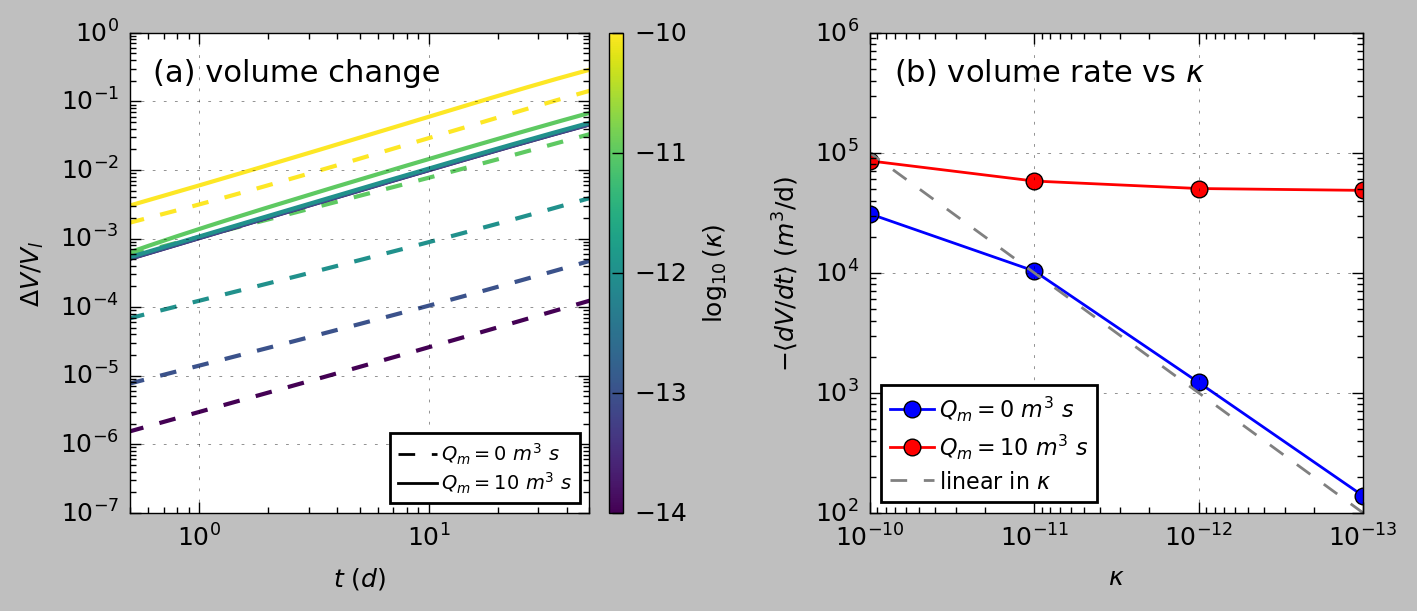

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import scipy.io as sio
from mpl_toolkits.axes_grid1 import make_axes_locatable

casenames1 = ['n2d_0m3s_kappa1e_10_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_11_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_12_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_13_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_0m3s_kappa1e_14_mu1e3_hbreg5e_3_V1e7_drainage']
casenames1 = casenames1[::-1]  # reverse the order
casenames2 = ['n2d_10m3s_kappa1e_10_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_11_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_12_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_13_mu1e3_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_14_mu1e3_hbreg5e_3_V1e7_drainage']
casenames2 = casenames2[::-1]  # reverse the order

fig, ax = plt.subplots(1,2,figsize=(7, 3), dpi=100)
plt.style.use('classic')
plt.rcParams["figure.dpi"] = 600
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams['axes.labelsize'] = 8  # 坐标轴标签字体大小
plt.rcParams['xtick.labelsize'] = 8 # X轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 8 # Y轴刻度字体大小
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

ax1 = plt.subplot(121)

vkappa = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10])
t_start = []
t_end = []
fontsize_panel = 9


class VolumeAnalysis:
    def __init__(self, casenames, vkappa):
        self.casenames = casenames
        self.vkappa = vkappa
        self.avg_dVdt = []
        # set up a color scheme
        self.colors = plt.cm.viridis(np.linspace(0, 1, len(casenames)))

    def process_case(self, casename, vkappa_value, i, ax1):
        mat_path = os.path.join('results', casename, casename + '.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)

        tt = raw['tt']
        ps = raw['ps']

        ps_hb = np.float64(ps['hb'])
        ps_x = np.float64(ps['x'])
        ps_S = np.float64(ps['S'])
        ps_h = np.float64(ps['h'])
        ps_t = np.float64(ps['t'])

        V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
        dVdt = np.gradient(V_b, ps_t*(24*60*60))  # velocity in m/s

        t = (ps_t / (24*60*60)) * np.float64(tt['t'])

        idx_start = np.where((V_b > 0.9 * np.max(V_b)) & (dVdt < 0))[0][0]
        idx_end = np.where(t > t[idx_start] + 1)[0][0]
        Vb0 = V_b[idx_start]
        Vbend = V_b[idx_end]
        self.avg_dVdt.append((Vbend - Vb0) / (t[idx_end] - t[idx_start]))
        exp = int(np.log10(vkappa_value))
        if casename.startswith('n2d_0m3s'):
            ax1.plot(t - t[idx_start], 1 - V_b / Vb0, linewidth=1.5, linestyle='--', color=self.colors[i])
            # label=rf'$Q_m=0~m^3~s$'
        else:
            ax1.plot(t - t[idx_start], 1 - V_b / Vb0, linewidth=1.5, color=self.colors[i])
            # label=rf'$Q_m=10~m^3~s$'

    def analyze(self, ax1):
        for i, casename in enumerate(self.casenames):
            self.process_case(casename, self.vkappa[i], i, ax1)

# Instantiate and use the class
volume_analysis = VolumeAnalysis(casenames1, vkappa)
volume_analysis.analyze(ax1)
avg_dVdt1 = volume_analysis.avg_dVdt
volume_analysis = VolumeAnalysis(casenames2, vkappa)
volume_analysis.analyze(ax1)
avg_dVdt2 = volume_analysis.avg_dVdt

# create two invisible lines to show legend
ax1.plot([], [], color='k', linewidth=1.0, linestyle='--', label=rf'$Q_m=0~m^3~s$')
ax1.plot([], [], color='k', linewidth=1.0, label=rf'$Q_m=10~m^3~s$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(5e-1, 50)
ax1.set_ylim(1e-7, 1)
ax1.set_xlabel(r'$t~(d)$',fontsize = fontsize_panel)
ax1.set_ylabel(r'$\Delta V/V_l$',fontsize = fontsize_panel)
ax1.tick_params(axis='both', labelsize=fontsize_panel) 
ax1.text(0.05, 0.9, r'(a) volume change', fontsize = fontsize_panel+2, transform=ax1.transAxes)
ax1.legend(loc='lower right', fontsize=fontsize_panel-2, frameon=True, handletextpad=0.2, ncol=1, labelspacing=0.2, numpoints=1)
ax1.grid(alpha=0.5)

# add a colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.log10(vkappa.min()), vmax=np.log10(vkappa.max())))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax1)
cbar.set_label(r'$\log_{10}(\kappa)$', fontsize=fontsize_panel)
cbar.ax.tick_params(labelsize=fontsize_panel)
cbar.set_ticks(np.arange(np.floor(np.log10(vkappa.min())), np.ceil(np.log10(vkappa.max())) + 1, 1))

# ================= Panel (b): speed vs volume =================
ax2 = plt.subplot(122)
# move ax2 to the right
ax2.set_visible(False)  # Hide original axes
# Get positions of ax2
pos_ax2  = ax2.get_position()
ax2_width = pos_ax2.x1 - pos_ax2.x0
ax2_height = pos_ax2.y1 - pos_ax2.y0
ax2_pos = [pos_ax2.x0+0.30*ax2_width, pos_ax2.y0, ax2_width, ax2_height]
ax2 = fig.add_axes(ax2_pos)

avg_dVdt1 = np.array(avg_dVdt1)
ax2.plot(vkappa, -avg_dVdt1, marker='o', linestyle='-', linewidth=1.0, color='b',label=rf'$Q_m=0~m^3~s$')
avg_dVdt2 = np.array(avg_dVdt2)
ax2.plot(vkappa, -avg_dVdt2, marker='o', linestyle='-', linewidth=1.0, color='r',label=rf'$Q_m=10~m^3~s$')
ax2.plot(vkappa, 1e15*vkappa**(1), linestyle='--', linewidth=1.0, color='gray', label=r'linear in $\kappa$')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-10, 1e-13)
ax2.set_ylim(1e2, 1e6)
ax2.set_xlabel(r'$\kappa$',fontsize = fontsize_panel)
ax2.set_ylabel(r'$-\langle {dV/dt} \rangle$ ($m^3$/d)',fontsize = fontsize_panel)
ax2.tick_params(axis='both', labelsize=fontsize_panel) 
ax2.text(0.05, 0.9, r'(b) volume rate vs $\kappa$', fontsize = fontsize_panel+2, transform=ax2.transAxes)
ax2.legend(loc='lower left', fontsize=fontsize_panel-1, frameon=True, handletextpad=0.2, ncol=1, labelspacing=0.4, numpoints=1)
ax2.grid(alpha=0.5)


fig.savefig(
    './results/figures/Fig6_volume.png',
    dpi=600,
    transparent=False,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()